In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model'

### Dataset
- load data from multi-stocks

In [29]:
from glob import glob

paths = glob("/home/jovyan/graph-stock-pred/Astock/data/pre/*-transformed.csv")
df = pd.DataFrame()
for path in tqdm(paths):
    df = pd.concat([df, pd.read_csv(path)])
df.head()
df.info()

100%|██████████| 16/16 [00:00<00:00, 69.94it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17456 entries, 0 to 1090
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17456 non-null  object 
 1   open           17456 non-null  float64
 2   high           17456 non-null  float64
 3   low            17456 non-null  float64
 4   close          17456 non-null  float64
 5   pre_close      17456 non-null  float64
 6   change         17456 non-null  float64
 7   pct_chg        17456 non-null  float64
 8   ADX            17040 non-null  float64
 9   MACD           16944 non-null  float64
 10  MACDsignal     16944 non-null  float64
 11  MACDhist       16944 non-null  float64
 12  RSI            17248 non-null  float64
 13  ATR            17248 non-null  float64
 14  OBV            17456 non-null  float64
 15  BETA           17392 non-null  float64
 16  upperBAND      17408 non-null  float64
 17  middleBAND     17408 non-null  float64
 18  lowerBA

- split train, val, test, ood datasets by date


In [30]:
# train: 80% from 2018.07 - 2021.12 
# val: 10% from 2018.07 - 2021.12 
# test: 10% from 2018.07 - 2021.12 
# ood: 2022.01 - 2022.06

df_train = df[df["date"]<"2022-01-01"].reset_index(drop=True)
df_ood = df[(df["date"]>="2022-01-01") & (df["date"]<"2022-07-01")].reset_index(drop=True)

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_test.sample(frac=0.5)
df_test = df_test.drop(df_val.index)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)

(12467, 33) (1558, 33) (1559, 33) (1872, 33)


In [37]:
# train: 2018.07 - 2021.06
df_train = df[df["date"]<"2021-07-01"].reset_index(drop=True)
# val: 2021.07 - 2021.09
df_val = df[(df["date"]>="2021-07-01") & (df["date"]<"2021-10-01")].reset_index(drop=True)
# test: 2021.10 - 2021.12
df_test = df[(df["date"]>="2021-10-01") & (df["date"]<"2022-01-01")].reset_index(drop=True)
# ood: 2022.01 - 2022.06
df_ood = df[(df["date"]>="2022-01-01") & (df["date"]<"2022-07-01")].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)

(13536, 33) (1024, 33) (1024, 33) (1872, 33)


- compute `label` column from `pct_chg` 
    - Thesis uses: $(close - pre close) / close$, but stock price change should devide by previous price. We corrected here
- We uese `qcut` and the distribution of `pct_chg` between 2018/07/02 - 2022/06/30 is: 
    ```
        (-0.0686, -0.00503]    325
        (0.0069, 0.0997]       325
        (-0.00503, 0.0069]     324
    ```
- Then filter out days with no news

In [31]:
def gen_label(df):
    df["label"] = pd.qcut(df['pct_chg'], q=3, labels=[0,1,2])
    return df


df_train = gen_label(df=df_train)
df_val = gen_label(df=df_val)
df_test = gen_label(df=df_test)
df_ood = gen_label(df=df_ood)

df_train = df_train[df_train.titles.notnull()].reset_index(drop=True)
df_val = df_val[df_val.titles.notnull()].reset_index(drop=True)
df_test = df_test[df_test.titles.notnull()].reset_index(drop=True)
df_ood = df_ood[df_ood.titles.notnull()].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)


(3813, 34) (476, 34) (511, 34) (1031, 34)


In [32]:
df_train[["pct_chg","label"]].describe(), df_val[["pct_chg","label"]].describe(), df_test[["pct_chg","label"]].describe()
df_ood[["pct_chg","label"]].describe()

,pct_chg
count,1031.000000
mean,-0.000522
std,0.027225
min,-0.098569
25%,-0.015739
50%,-0.001040
75%,0.013164
max,0.100000


- compute verb-A0-A1 triplets number as `AV_num`

In [33]:
df_train["AV_num"] = df_train["verbA0A1"].apply(lambda x: len(eval(x)))
df_val["AV_num"] = df_val["verbA0A1"].apply(lambda x: len(eval(x)))
df_test["AV_num"] = df_test["verbA0A1"].apply(lambda x: len(eval(x)))
df_ood["AV_num"] = df_ood["verbA0A1"].apply(lambda x: len(eval(x)))

- merge `stock_factors` to array in one column

Now each sample will have these factors: 
```
    ADX                                                11.493372
    MACD                                               -1.556851
    MACDsignal                                         -1.221986
    MACDhist                                           -0.334864
    RSI                                                44.103107
    ATR                                                 3.732317
    OBV                                              -71157437.0
    BETA                                                1.032639
    upperBAND                                         195.743838
    middleBAND                                        193.008206
    lowerBAND                                         190.272574
    成交股數                                              28663220.0
    成交筆數                                                  7758.0
    成交金額                                            6173115899.0
    殖利率(%)                                                  3.73
    本益比                                                    16.12
    股價淨值比                                                   3.46
```

In [34]:
# remove nan rows
factor_cols = ["ADX","MACD","MACDsignal","MACDhist","RSI","ATR","OBV","BETA","upperBAND","middleBAND","lowerBAND","成交股數","成交筆數","成交金額","殖利率(%)","本益比","股價淨值比"]
for col in tqdm(factor_cols):
    df_train = df_train[df_train[col].notnull()].reset_index(drop=True)
    df_val = df_val[df_val[col].notnull()].reset_index(drop=True)
    df_test = df_test[df_test[col].notnull()].reset_index(drop=True)
    df_ood = df_ood[df_ood[col].notnull()].reset_index(drop=True)


# Normalization all factors to the same scale
standard_scaler = StandardScaler()
# 1. fit from training set
standard_scaler.fit(df_train[factor_cols])
# 2. transform train, val, test, ood sets, since stock factors are used in training feature, if we don't know future price, we can't normalize it with the future time duration
df_train[factor_cols] = standard_scaler.transform(df_train[factor_cols])
df_val[factor_cols] = standard_scaler.transform(df_val[factor_cols])
df_test[factor_cols] = standard_scaler.transform(df_test[factor_cols])
df_ood[factor_cols] = standard_scaler.transform(df_ood[factor_cols])

100%|██████████| 17/17 [00:00<00:00, 311.13it/s]


In [35]:
# disbutions of stock factors have huge difference between train, val, test, odd sets
df_ood[factor_cols].describe()

,ADX,MACD,MACDsignal,MACDhist,RSI,ATR,OBV,BETA,upperBAND,middleBAND,lowerBAND,成交股數,成交筆數,成交金額,殖利率(%),本益比,股價淨值比
count,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,-0.212638,-0.403629,-0.405320,-0.081285,-0.579616,0.036257,0.593025,-0.005024,0.043940,0.042693,0.041365,-0.132448,0.045810,-0.079999,0.341053,-0.232647,-0.091386
std,0.766514,0.916618,0.897444,1.047910,0.933763,0.999478,1.012624,0.489566,1.104521,1.101077,1.097217,0.595378,0.797022,0.746214,1.636098,0.417554,0.849880
min,-1.470384,-4.867690,-4.342935,-6.023422,-2.867218,-0.644171,-0.797139,-3.693150,-0.519720,-0.515604,-0.511090,-0.740519,-0.750970,-0.577486,-1.303126,-0.387766,-0.882346
25%,-0.770238,-0.397536,-0.408446,-0.171938,-1.231204,-0.540630,-0.481898,-0.277558,-0.469868,-0.467701,-0.464520,-0.485148,-0.450516,-0.498552,-0.552731,-0.370136,-0.680917
50%,-0.366219,-0.287045,-0.300072,-0.023299,-0.615185,-0.358914,0.736535,0.008368,-0.390584,-0.386916,-0.383374,-0.301737,-0.175167,-0.365407,0.018893,-0.307485,-0.219867
75%,0.226569,-0.184686,-0.188085,0.097122,-0.057537,-0.117702,1.262399,0.282053,-0.210780,-0.209869,-0.223621,-0.005354,0.236672,-0.046370,0.643487,-0.219723,-0.036342
max,2.501528,4.115770,3.491525,4.865049,2.393932,3.032884,2.928488,2.343626,3.550725,3.529668,3.523461,5.923989,6.367447,5.120882,9.423105,4.000977,2.752339


In [36]:
# 3. merge it to one column
def merge_factors(df):
    factor_values = df[factor_cols].values
    df["stock_factors"] = 0
    for i in tqdm(range(df.shape[0])):
        df.loc[i, "stock_factors"] = str(factor_values[i].tolist())
    df = df.drop(factor_cols, axis=1)
    return df

df_train = merge_factors(df=df_train)
df_val = merge_factors(df=df_val)
df_test = merge_factors(df=df_test)
df_ood = merge_factors(df=df_ood)
df_train["stock_factors"]

100%|██████████| 966/966 [00:00<00:00, 12423.57it/s]


0       [-0.9392160968559649, -0.25256360486394674, -0...
1       [-0.9030656630777636, -0.2506964345437408, -0....
2       [-1.053264392077684, -0.2505141117397429, -0.2...
3       [-0.9630569394036578, -0.2489039690422418, -0....
4       [0.7654410752787565, -0.23768822362883638, -0....
                              ...                        
2989    [-0.27953503451935896, -0.21650721269386503, -...
2990    [-0.17669761638285064, -0.2039810008777213, -0...
2991    [-1.2500518254403596, -0.27266294117473866, -0...
2992    [-1.2201032975634616, -0.26037208864985545, -0...
2993    [-1.0208954034218096, -0.24920483004919916, -0...
Name: stock_factors, Length: 2994, dtype: object

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994 entries, 0 to 2993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           2994 non-null   object  
 1   open           2994 non-null   float64 
 2   high           2994 non-null   float64 
 3   low            2994 non-null   float64 
 4   close          2994 non-null   float64 
 5   pre_close      2994 non-null   float64 
 6   change         2994 non-null   float64 
 7   pct_chg        2994 non-null   float64 
 8   affected_date  2994 non-null   object  
 9   news_count     2994 non-null   float64 
 10  titles         2994 non-null   object  
 11  verbA0A1       2994 non-null   object  
 12  verb           2994 non-null   object  
 13  A0             2994 non-null   object  
 14  A1             2994 non-null   object  
 15  stock_id       2994 non-null   int64   
 16  label          2994 non-null   category
 17  AV_num         2994 non-null   in

## Generating the masks of verb, A0, A1

In [38]:
max_len = 512

def string_to_tuples_list(text):
    if text is np.nan or text =='[]':
        return []
    text = ''.join(text.split('], ['))
    tmp = eval(text.strip('[').strip(']'))
    if not isinstance(tmp[0],tuple):
        return [tmp]
    return list(tmp)

def mask(df):
    df = df.reset_index(drop = True)
    df['verb_mask'] = 0
    df['A0_mask'] = 0
    df['A1_mask'] = 0
    df['verb_mask'] = df['verb_mask'].astype('object')
    df['A0_mask'] = df['A0_mask'].astype('object')
    df['A1_mask'] = df['A1_mask'].astype('object')
    for index,row in tqdm(df.iterrows()):

        df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
        AV_num = 0
        for k,col in enumerate(['verb','A0','A1']):
            masks = []
            for j in range(len(row['verbA0A1'])):
                mask = np.zeros(max_len - 1)
                idx = []
                for v in row['verbA0A1'][j][k]:
                    idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
                counter = Counter(idx)

                mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
                mask.insert(0,0)
                masks.append(mask)
            AV_num = len(masks)
            for i in range(10 - len(masks)):
                masks.append(np.zeros(max_len))
            while len(masks)>10:
                masks.pop()
            name = col+'_mask'
            df.at[index,name] = np.array(masks)
        if AV_num>10:
            AV_num=10
        df.loc[index,'AV_num'] = int(AV_num)
    df.AV_num = df.AV_num.astype('int')
    df.stock_factors = df.stock_factors.apply(np.array)
    return df

In [39]:
df_train = df_train[df_train["AV_num"] > 0].reset_index(drop=True)
df_val = df_val[df_val["AV_num"] > 0].reset_index(drop=True)
df_test = df_test[df_test["AV_num"] > 0].reset_index(drop=True)
df_ood = df_ood[df_ood["AV_num"] > 0].reset_index(drop=True)


for col in ['verb','A0','A1']:
    df_train[col] = df_train[col].apply(string_to_tuples_list)
    df_val[col] = df_val[col].apply(string_to_tuples_list)
    df_test[col] = df_test[col].apply(string_to_tuples_list)
    df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
    df_train[col] = df_train[col].apply(ast.literal_eval)
    df_val[col] = df_val[col].apply(ast.literal_eval)
    df_test[col] = df_test[col].apply(ast.literal_eval)
    df_ood[col] = df_ood[col].apply(ast.literal_eval)


df_train = mask(df=df_train)
df_val = mask(df=df_val)
df_test = mask(df=df_test)
df_ood = mask(df=df_ood)

df_train.info()
df_val.info()
df_test.info()
df_ood.info()

2693it [00:07, 345.95it/s]
327it [00:00, 366.67it/s]
364it [00:00, 387.58it/s]
834it [00:02, 375.27it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           2693 non-null   object  
 1   open           2693 non-null   float64 
 2   high           2693 non-null   float64 
 3   low            2693 non-null   float64 
 4   close          2693 non-null   float64 
 5   pre_close      2693 non-null   float64 
 6   change         2693 non-null   float64 
 7   pct_chg        2693 non-null   float64 
 8   affected_date  2693 non-null   object  
 9   news_count     2693 non-null   float64 
 10  titles         2693 non-null   object  
 11  verbA0A1       2693 non-null   object  
 12  verb           2693 non-null   object  
 13  A0             2693 non-null   object  
 14  A1             2693 non-null   object  
 15  stock_id       2693 non-null   int64   
 16  label          2693 non-null   category
 17  AV_num         2693 non-null   in

In [40]:
# df_train["titles"].apply(lambda x: len(x)).value_counts().sort_index()
df_train["verbA0A1"][100]

[[[(3, 1)], [(0, 2)], [(4, 2)]], [[(16, 1)], [(0, 16)], [(17, 7)]]]

## Create Dataloader

In [41]:
BATCH_SIZE = 16
class_names = ['negative', 'neutral', 'positive']
class GPReviewDataset(Dataset):
    def __init__(self, titles, targets, verb, A0, A1, AV_num, tokenizer, stock_factors, max_len):
        self.titles = titles
        self.targets = targets
        self.stock_factors = stock_factors
        self.verb = verb
        self.A0 = A0
        self.A1 = A1
        self.AV_num = AV_num
        self.tokenizer = tokenizer
        self.max_len = max_len
      
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, item):
        titles = str(self.titles[item])
        target = self.targets[item]
        stock_factors = self.stock_factors[item]
        v = self.verb[item]
        a0 = self.A0[item]
        a1 = self.A1[item]
        av_num = self.AV_num[item]

        encoding = self.tokenizer.encode_plus(
            titles,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'titles': titles,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'stock_factors':torch.tensor(stock_factors),
            'verb': torch.tensor(v),
            'A0': torch.tensor(a0),
            'A1': torch.tensor(a1),
            'AV_num': torch.tensor(av_num)
        }

In [42]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        titles=df.titles.to_numpy(),
        targets=df.label.to_numpy(),
        stock_factors = df.stock_factors,
        verb = df.verb_mask,
        A0 = df.A0_mask,
        A1 = df.A1_mask,
        AV_num = df.AV_num,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

In [45]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [46]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['titles', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [47]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
        self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304, nhead=1).to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2).to(device)
        self.drop = nn.Dropout(p=0.1).to(device)
        self.out1 = nn.Linear((self.bert.config.hidden_size*3)*10, (self.bert.config.hidden_size*3)*3).to(device)
        self.out = nn.Linear((self.bert.config.hidden_size*3)*3, n_classes).to(device)
        self.avgpool = nn.AvgPool2d((3,2), stride=2).to(device)
        self.flatten2 = nn.Flatten(2,-1).to(device)
        self.flatten = nn.Flatten(1,-1).to(device)
        self.sig = nn.Sigmoid().to(device)
        self.relu = nn.ReLU().to(device)
        self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size).to(device)
    
    def forward(self, input_ids, attention_mask, verb, A0, A1, AV_num):
        # get bert embedding 
        hidden_state = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0].to(device)
        batch = hidden_state.shape[0]
        verb_tmp = verb.clone().to(device)

        # mask verb
        AV_idx = []
        for idx, num in enumerate(AV_num):
            self_label = torch.randint(0,num,(1,))[0].to(device)
            AV_idx.append(self_label)
            verb_tmp[idx,self_label,:]=0

        # verb label
        AV_idx = torch.tensor(AV_idx).to(device)

        V_mask = torch.unsqueeze(verb,3).to(device)
        V_mask = torch.cat(768 * [V_mask],3).to(device)
        V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        K = self.Key(torch.squeeze(V_mask.float())).to(device)
        
        # get verb embedding after masking(8*10*1*768)
        V_mask_mask = torch.unsqueeze(verb_tmp,3).to(device)
        V_mask_mask = torch.cat(768 * [V_mask_mask],3).to(device)
        transformer_input = torch.mean(V_mask_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)

        # get A0 embedding(8*10*2*768)
        A0_mask = torch.unsqueeze(A0,3).to(device)
        A0_mask = torch.cat(768 * [A0_mask],3).to(device)
        A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A0_mask],2).to(device)

        # get A1 embedding(8*10*3*768)
        A1_mask = torch.unsqueeze(A1,3).to(device)
        A1_mask = torch.cat(768 * [A1_mask],3).to(device)
        A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A1_mask],2).to(device)

        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # turn to (10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])

        # get transformer output(10*8*2304)
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # turn to (8*10*2304)
        self_pred = torch.zeros((batch,10)).to(device)
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        # Q For CL
        for idx,i in enumerate(AV_idx):
            Q = torch.unsqueeze(self.Querry(transformer_output[idx,i,:768]),0).to(device)
            self_pred[idx]=(Q @ K[idx].T).to(device)

        # get transformer input for classification(8*10*3*768)
        transformer_input = torch.cat([V_mask,A0_mask,A1_mask],2).to(device)
        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # get transformer output(10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # handle exception
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        output = self.flatten(transformer_output.float()).to(device)
        output = self.sig(output).to(device)
        output = self.out1(output).to(device)
        output = self.sig(output).to(device)
        output = self.drop(output).to(device)
        output = self.out(output).to(device)

        return output,self_pred,AV_idx


In [48]:
model = SentimentClassifier(n_classes=3)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)


Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


In [54]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
verbs = data['verb'].to(device)
A0s = data['A0'].to(device)
A1s = data['A1'].to(device)
AV_num = data['AV_num'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


In [55]:
F.softmax(model(input_ids, attention_mask, verb=verbs, A0=A0s, A1=A1s, AV_num=AV_num)[0], dim=1)

tensor([[0.1752, 0.4309, 0.3939],
        [0.1621, 0.3578, 0.4801],
        [0.2028, 0.3698, 0.4274],
        [0.1846, 0.3648, 0.4507],
        [0.1791, 0.4375, 0.3834],
        [0.1599, 0.3506, 0.4895],
        [0.1976, 0.3713, 0.4311],
        [0.1871, 0.3687, 0.4442],
        [0.1763, 0.4364, 0.3873],
        [0.1619, 0.3517, 0.4864],
        [0.2031, 0.3714, 0.4255],
        [0.1838, 0.3721, 0.4441],
        [0.1733, 0.4375, 0.3892],
        [0.1619, 0.3537, 0.4844],
        [0.2029, 0.3715, 0.4256],
        [0.1868, 0.3643, 0.4489]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [49]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    correct_predictions_verbs = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        verb = d["verb"].to(device)
        A0 = d["A0"].to(device)
        A1 = d["A1"].to(device)
        AV_num = d["AV_num"].to(device)

        outputs,self_outputs,self_labels = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            verb = verb,
            A0 = A0,
            A1 = A1,
            AV_num = AV_num
        )
        self_outputs = self_outputs.to(device)
        self_labels = self_labels.to(device)

        if outputs.dim()==1:
            outputs = torch.unsqueeze(outputs,0)
        _, preds = torch.max(outputs, dim=1)
        _, self_preds = torch.max(self_outputs, dim=1)
        
        # print(targets.shape,outputs.shape)
        loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

        correct_predictions += torch.sum(preds == targets)
        correct_predictions_verbs += torch.sum(self_preds == self_labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses), correct_predictions_verbs.double()/n_examples

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            verb = d["verb"].to(device)
            A0 = d["A0"].to(device)
            A1 = d["A1"].to(device)
            AV_num = d["AV_num"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                verb = verb,
                A0 = A0,
                A1 = A1,
                AV_num = AV_num
            )[0]
            
            if outputs.dim()==1:
                outputs = torch.unsqueeze(outputs,0)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
history = defaultdict(list)
best_accuracy = 0

In [53]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy {cl_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBert_SRL(FC)_CL(V).bin')
    best_accuracy = val_acc


Epoch 1/10
----------
Train loss 1.2497852222453913 accuracy 0.3650204233197178 cl_accuracy 0.4184923876717415
Val   loss 1.082663362934476 accuracy 0.3730886850152905

Epoch 2/10
----------
Train loss 1.1044861519125087 accuracy 0.4303750464166357 cl_accuracy 0.4225770516152989
Val   loss 1.0592458446820576 accuracy 0.3944954128440367

Epoch 3/10
----------
Train loss 1.0554066388564702 accuracy 0.45302636464909024 cl_accuracy 0.4184923876717415
Val   loss 1.074936372893197 accuracy 0.4434250764525994

Epoch 4/10
----------
Train loss 1.0002328227962969 accuracy 0.5139249907166729 cl_accuracy 0.4251763832157445
Val   loss 1.0773264538674128 accuracy 0.4709480122324159

Epoch 5/10
----------
Train loss 0.9415564995545608 accuracy 0.5837356108429261 cl_accuracy 0.428518380987746
Val   loss 1.2080329259236653 accuracy 0.39143730886850153

Epoch 6/10
----------
Train loss 0.8764222553495825 accuracy 0.6468622354251764 cl_accuracy 0.42406238395841067
Val   loss 1.3539522630827767 accuracy 

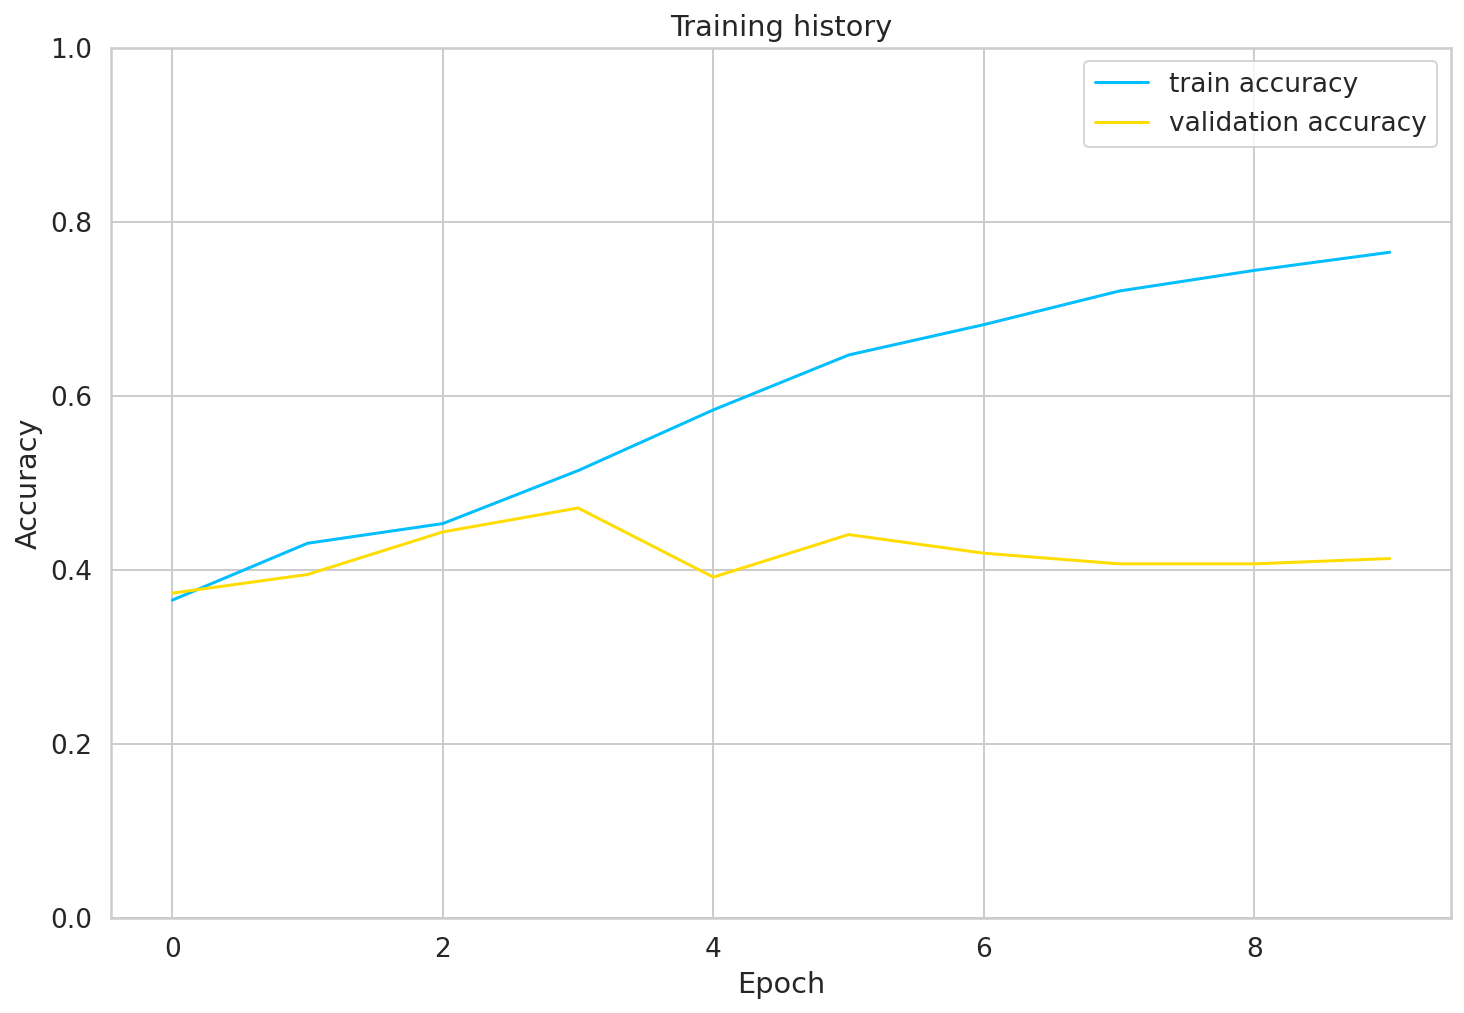

In [54]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [22]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)
model.load_state_dict(torch.load('Pretrained_RoBert_SRL(FC)_CL(V).bin'))

Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


<All keys matched successfully>

In [61]:
len(df_test)

889

In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.4642857142857143

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["titles"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )[0]
#       _, preds = torch.max(outputs, dim=1)
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [57]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

              precision    recall  f1-score   support

    negative     0.4745    0.5000    0.4869       130
     neutral     0.4483    0.2500    0.3210       104
    positive     0.4615    0.6000    0.5217       130

    accuracy                         0.4643       364
   macro avg     0.4614    0.4500    0.4432       364
weighted avg     0.4624    0.4643    0.4519       364



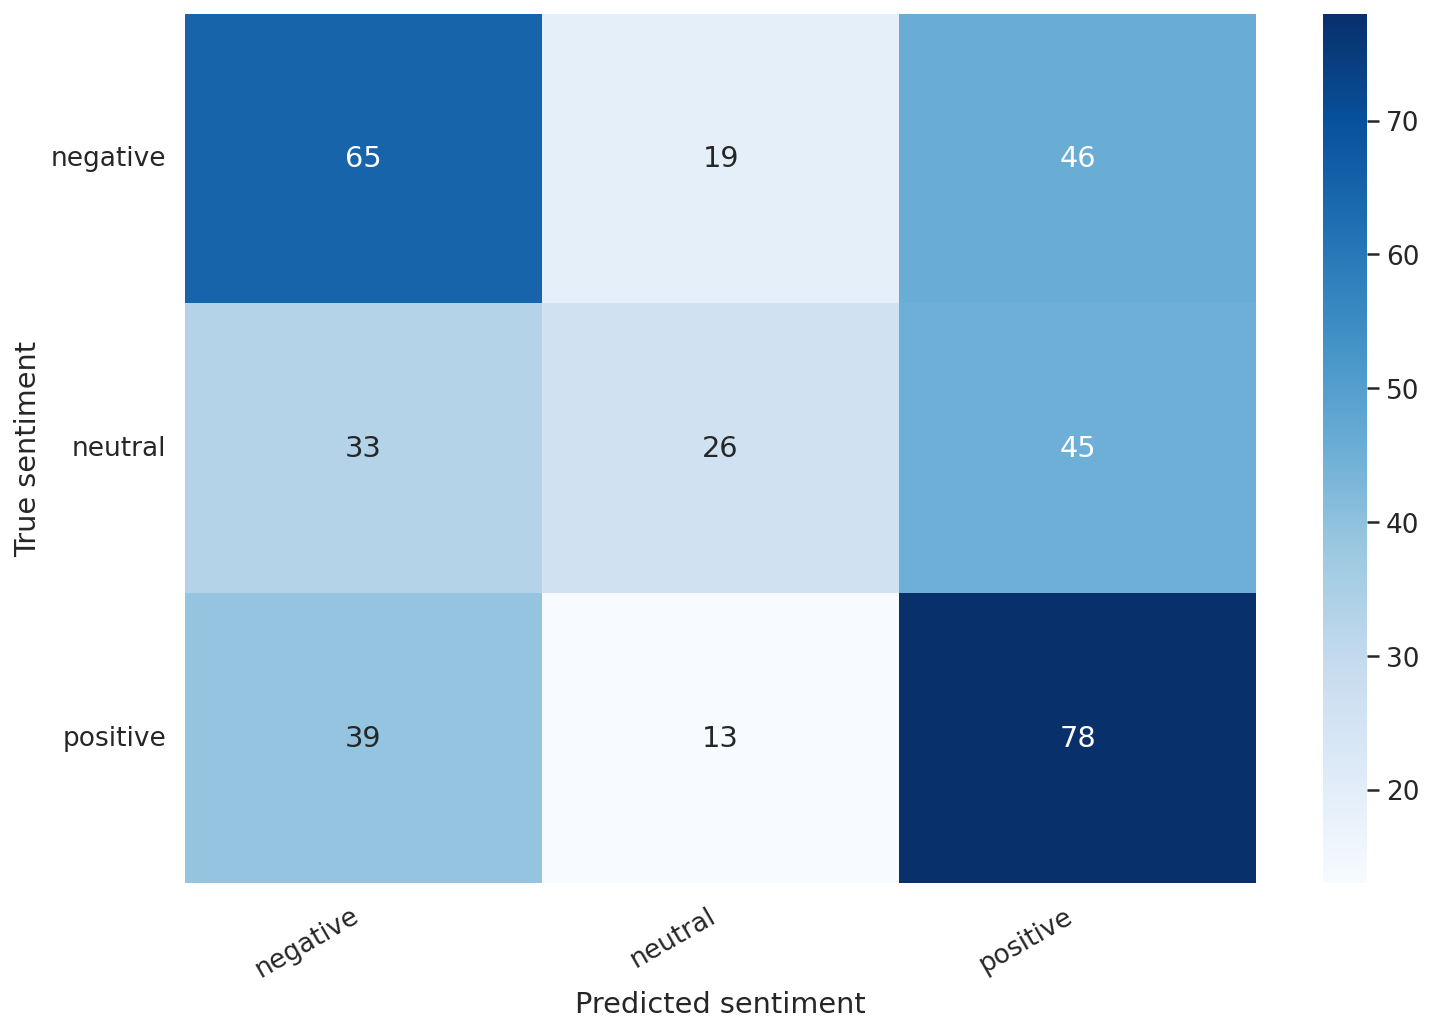

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

    negative     0.4272    0.4664    0.4459       283
     neutral     0.5048    0.2015    0.2880       263
    positive     0.4262    0.6215    0.5056       288

    accuracy                         0.4365       834
   macro avg     0.4527    0.4298    0.4132       834
weighted avg     0.4513    0.4365    0.4168       834



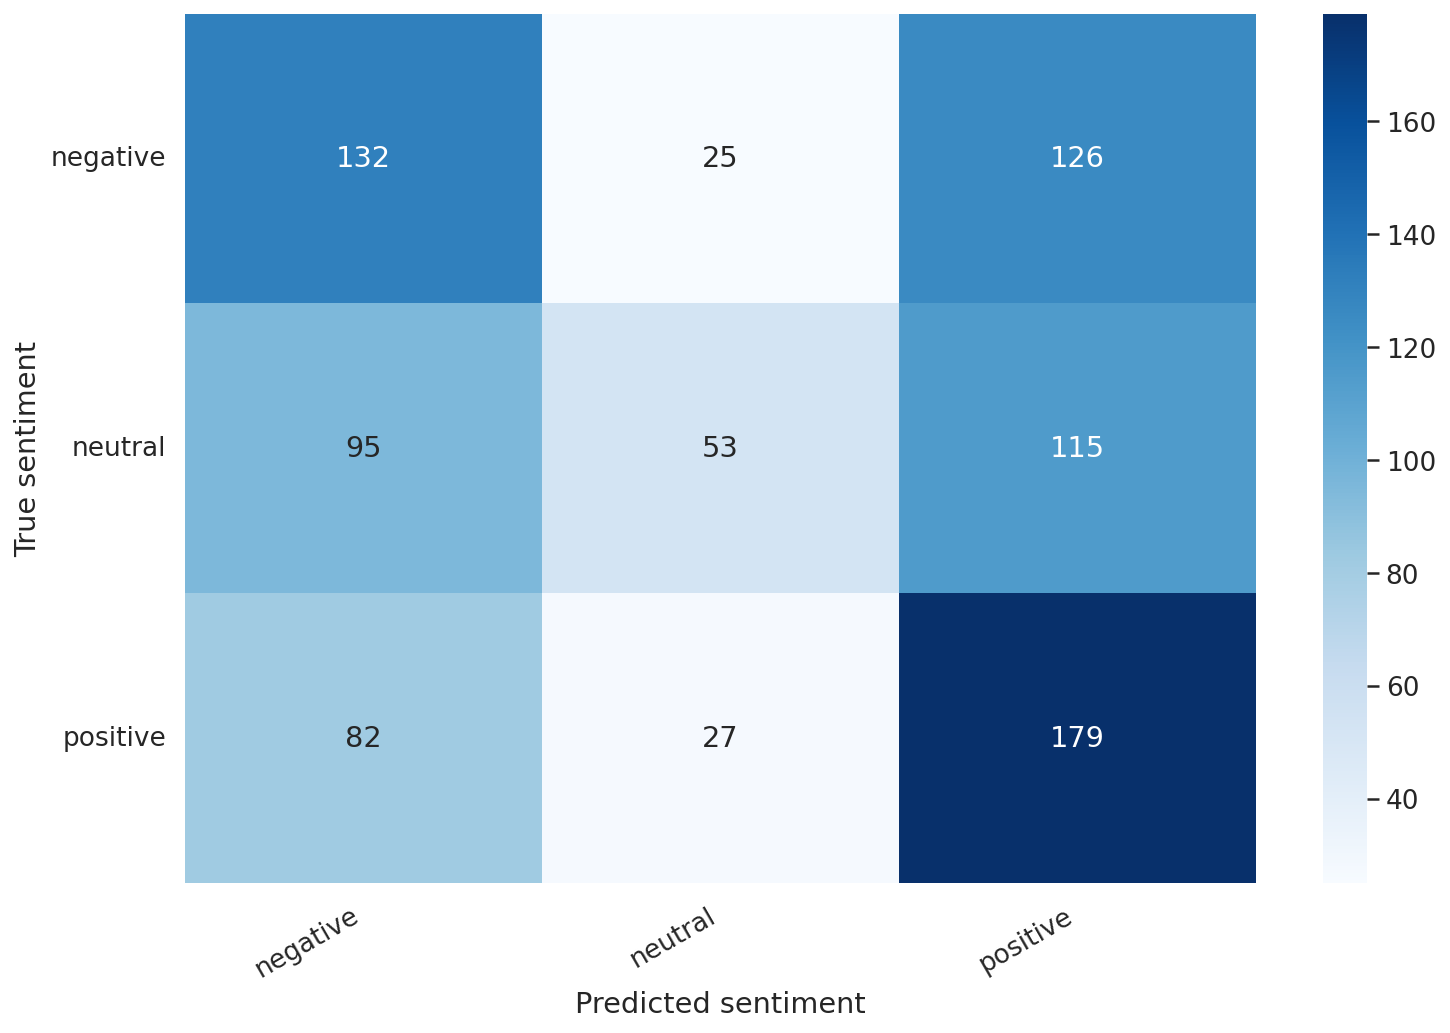

In [59]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [67]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0: 'text',1: 'prediction',2: 'probability',3: 'labels'})
df.to_csv('try_Pretrained_RoBert_SRL(FC)_V_ood.csv',sep='\t')